**Introduction & Objectives**

1.The goal of Milestone 2 is to extract meaningful features from preprocessed fitness device data and apply modeling techniques to understand trends and behavioral patterns.

2.This milestone lays the foundation for detecting health anomalies in later stages.

3.Focus areas include feature extraction, trend modeling, and unsupervised behavioral clustering.


**Environment Setup**

In [2]:
!pip install -q tsfresh prophet scikit-learn seaborn scipy


# Dataset Description

The dataset consists of fitness and lifestyle data collected from wearable devices. It includes physiological metrics, activity levels, sleep information, and demographic attributes for multiple individuals.

**Key Attributes:**

Heart Rate

Daily Steps

Sleep Duration

Blood Pressure (Systolic & Diastolic)

In [3]:
import pandas as pd

DATA_PATH = "/content/Clean.csv"

df = pd.read_csv(DATA_PATH)

# standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# sort properly
df = df.sort_values(['person_id', 'timestamp']).reset_index(drop=True)

print(df.shape)
df.head()


(374, 17)


,person_id,gender,age,occupation,job_category,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,weight_category,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,daily_steps,sleep_disorder,timestamp
0,1,Male,27,Software Engineer,Science and Technology,6.1,6,42,6,Overweight,2,126,83,77,4200,NaN,2025-03-08 11:12:00
1,2,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-04-13 17:14:00
2,3,Male,28,Doctor,Healthcare,6.2,6,60,8,Normal,1,125,80,75,10000,NaN,2025-07-26 10:59:00
3,4,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-27 16:17:00
4,5,Male,28,Sales Representative,Business Management,5.9,4,30,8,Obese,3,140,90,85,3000,Sleep Apnea,2025-01-29 03:46:00


In [7]:
ts_cols = [
    'heart_rate',
    'daily_steps',
    'sleep_duration',
    'stress_level'
]

meta_cols = [
    'gender', 'age', 'occupation', 'job_category',
    'bmi_category', 'weight_category', 'sleep_disorder'
]


In [5]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
le = LabelEncoder()

for col in meta_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


In [8]:
from scipy.stats import kurtosis, skew

stat_rows = []

for pid, g in df_encoded.groupby('person_id'):
    row = {'person_id': pid}
    for col in ts_cols:
        row[f'{col}_mean'] = g[col].mean()
        row[f'{col}_std'] = g[col].std()
        row[f'{col}_kurtosis'] = kurtosis(g[col])
        row[f'{col}_skewness'] = skew(g[col])
    stat_rows.append(row)

stat_features = pd.DataFrame(stat_rows)

stat_features.head()


,person_id,heart_rate_mean,heart_rate_std,heart_rate_kurtosis,heart_rate_skewness,daily_steps_mean,daily_steps_std,daily_steps_kurtosis,daily_steps_skewness,sleep_duration_mean,sleep_duration_std,sleep_duration_kurtosis,sleep_duration_skewness,stress_level_mean,stress_level_std,stress_level_kurtosis,stress_level_skewness
0,1,77.0,NaN,NaN,NaN,4200.0,NaN,NaN,NaN,6.1,NaN,NaN,NaN,6.0,NaN,NaN,NaN
1,2,75.0,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,6.2,NaN,NaN,NaN,8.0,NaN,NaN,NaN
2,3,75.0,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,6.2,NaN,NaN,NaN,8.0,NaN,NaN,NaN
3,4,85.0,NaN,NaN,NaN,3000.0,NaN,NaN,NaN,5.9,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,5,85.0,NaN,NaN,NaN,3000.0,NaN,NaN,NaN,5.9,NaN,NaN,NaN,8.0,NaN,NaN,NaN


# **Feature Extraction**
**Statistical Feature Extraction**

Basic statistical features such as mean, standard deviation, skewness, and kurtosis are computed for heart rate, steps, and sleep duration on a per-person basis. These features summarize individual health behavior over time.

In [9]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

tsfresh_input = df_encoded[['person_id', 'timestamp'] + ts_cols]

tsfresh_features = extract_features(
    tsfresh_input,
    column_id='person_id',
    column_sort='timestamp',
    default_fc_parameters=EfficientFCParameters(),
    n_jobs=0
)

impute(tsfresh_features)

print(tsfresh_features.shape)






Feature Extraction: 100%|██████████| 1496/1496 [01:56<00:00, 12.88it/s]
/usr/local/lib/python3.12/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['heart_rate__mean_abs_change' 'heart_rate__mean_change'
 'heart_rate__mean_second_derivative_central' ...
 'stress_level__permutation_entropy__dimension_7__tau_1'
 'stress_level__query_similarity_count__query_None__threshold_0.0'
 'stress_level__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


(374, 3108)


**Feature Selection**

Variance Thresholding is applied to remove low-variance and non-informative features. This reduces dimensionality and improves clustering performance by retaining only relevant features.

In [10]:
from sklearn.feature_selection import VarianceThreshold

# if only 1 user exists, skip selection
if tsfresh_features.shape[0] > 1:
    selector = VarianceThreshold(threshold=0.01)
    selector.fit(tsfresh_features)
    selected_cols = tsfresh_features.columns[selector.get_support()]
else:
    selected_cols = tsfresh_features.columns

print("Selected TSFresh Features:", len(selected_cols))



Selected TSFresh Features: 90


**Metadata Aggregation (PER PERSON)**

In [11]:
meta_features = (
    df_encoded
    .groupby('person_id')[meta_cols]
    .mean()
    .reset_index()
)


**FINAL FEATURE MATRIX**

In [12]:
# reset tsfresh index safely
tsfresh_reset = tsfresh_features[selected_cols].reset_index()
tsfresh_reset = tsfresh_reset.rename(columns={'index': 'person_id'})

# merge everything
X_features = (
    stat_features
    .merge(tsfresh_reset, on='person_id', how='inner')
    .merge(meta_features, on='person_id', how='inner')
)

# remove id column
X_features = X_features.drop(columns=['person_id']).fillna(0)

print("Final Feature Matrix Shape:", X_features.shape)
X_features.head()


Final Feature Matrix Shape: (374, 113)


,heart_rate_mean,heart_rate_std,heart_rate_kurtosis,heart_rate_skewness,daily_steps_mean,daily_steps_std,daily_steps_kurtosis,daily_steps_skewness,sleep_duration_mean,sleep_duration_std,...,"stress_level__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","stress_level__fft_coefficient__attr_""real""__coeff_0","stress_level__fft_coefficient__attr_""abs""__coeff_0",gender,age,occupation,job_category,bmi_category,weight_category,sleep_disorder
0,77.0,0.0,0.0,0.0,4200.0,0.0,0.0,0.0,6.1,0.0,...,1.180587,6.0,6.0,1.0,0.0,8.0,4.0,2.0,1.0,2.0
1,75.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,6.2,0.0,...,1.574117,8.0,8.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0
2,75.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,6.2,0.0,...,1.574117,8.0,8.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0
3,85.0,0.0,0.0,0.0,3000.0,0.0,0.0,0.0,5.9,0.0,...,1.574117,8.0,8.0,1.0,1.0,6.0,0.0,1.0,2.0,1.0
4,85.0,0.0,0.0,0.0,3000.0,0.0,0.0,0.0,5.9,0.0,...,1.574117,8.0,8.0,1.0,1.0,6.0,0.0,1.0,2.0,1.0


# **2.Trend Modeling (Prophet)**

**1.Time-Series Trend Modeling using Prophet**

Facebook Prophet is used to model temporal trends and seasonality in heart rate, daily steps, and sleep duration. Prophet handles missing data and seasonal effects efficiently.

**2.Forecasting and Residual Analysis**

Future values are forecasted, and residuals (actual − predicted) are computed. Large deviations from expected trends indicate potential unusual or anomalous behavior.

**3.Visualization**

Each metric is visualized with confidence intervals, enabling clear interpretation of trends, seasonal patterns, and deviations.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


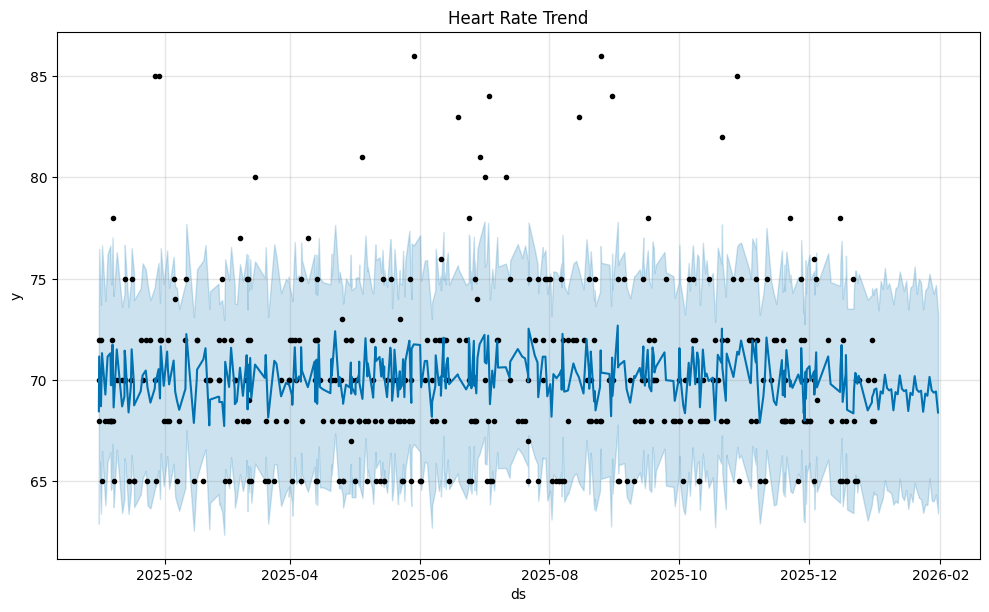

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


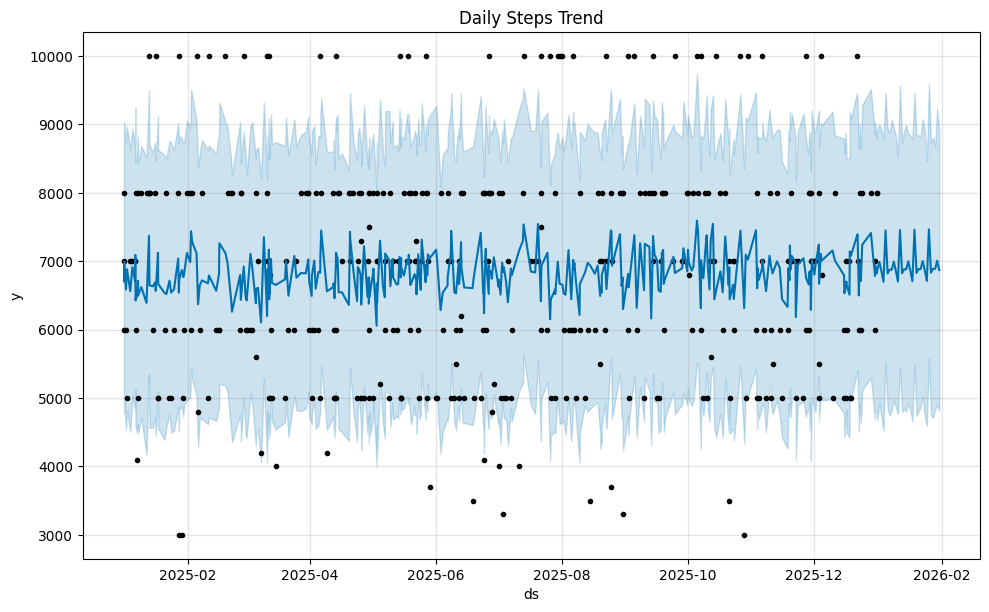

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


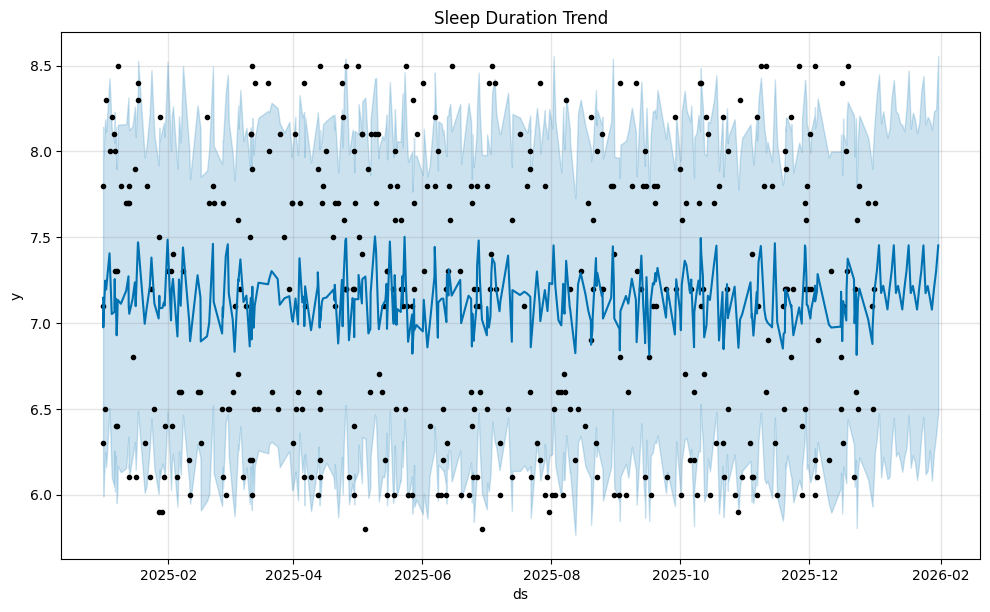

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


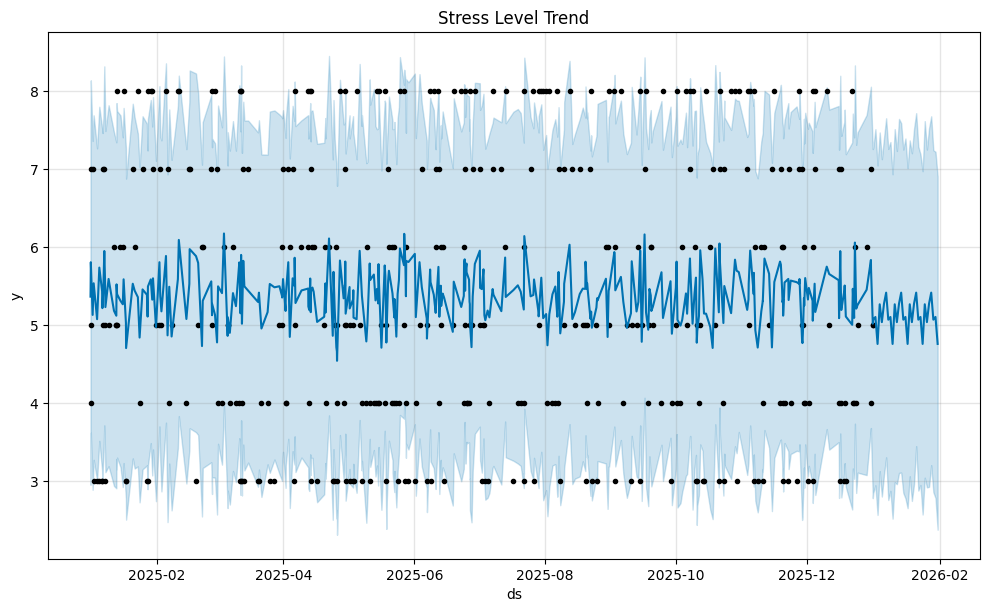

In [13]:
from prophet import Prophet
import matplotlib.pyplot as plt

def run_prophet(df, col):
    data = df[['timestamp', col]].rename(columns={'timestamp':'ds','col':'y'})
    data.columns = ['ds', 'y']

    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(data)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title(f"{col.replace('_',' ').title()} Trend")
    plt.show()

for col in ts_cols:
    run_prophet(df_encoded, col)


# **Behavioral Clustering**

In [14]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_features)




**Dimensionality Reduction (PCA)**

Principal Component Analysis (PCA) is applied to reduce the high-dimensional feature space into two components, enabling efficient clustering and visualization.

In [15]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_features)


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained Variance:", pca.explained_variance_ratio_)


Explained Variance: [0.55317062 0.2347042 ]


**Clustering Techniques**

1.KMeans is used to group individuals with similar health and activity patterns.

2.DBSCAN is used to detect atypical or isolated behavioral patterns that may represent abnormal behavior.


In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)
print(kmeans_labels)

[2 1 1 2 2 2 2 0 0 0 1 0 1 1 1 1 2 1 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2
 2 0 2 0 2 0 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2
 2 2 0 2 0 2 0 2 0 2 0 2 0 2 2 0 2 2 0 2 2 0 2 0 2 2 2 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 1 2 1 1 1 1 1 1 1 1 1 2 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 2 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_pca)
print(dbscan_labels)


[-1  0  0  1  1  1 -1  2  2  2  3  2  3  3  3  3  4  3  4  2  2  2  2  2
  2  2  2  2  2  2 -1 -1 -1  5  2  5  5  2  2  2  2  2  2  2  2  2  2  2
  2  2 -1 -1  5  2  5  5  2  5  5  2  5  5  5  5  5  5 -1  5 -1 -1  5  5
  5  5  5  5  5  5  5  5 -1 -1 -1 -1  2  6  7  7  7  7  7  7  2 -1  6  6
  6  6  6  6  6  6  6 -1  6 -1 -1 -1 -1  2  6  2  6  2  6  6  6  6  6  6
  6  6  6  6  6 -1  2  6  2  2  6  2  2  6  2  2  6  2  6  2  6  2  6  6
  2 -1  2  4 -1 -1 -1  2  2  2  2  2  2  2  2  2  2  8  8 -1 -1  2 -1  9
  9  2  2  2  2  2  2  2  2 10  2  2  2  2  2  2 11 11 12 10 12 10 12 10
 10 10 10 10 10 10 10 10 10  2  2  8 -1  2  2  2  2  2  2  2  2  2  2  2
  2  2  2 10 12 10 10 10 12 10 12 10 12 10 12 10 12 10 12 10 10 12 10 10
 12 10 10 12 10 12 10 11 10 10 -1 -1 12 12 12 12 12 12 12 12 12 12 12 -1
 -1  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  0 13  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 13 13 13 13  9  0  0  0 10 10 10 10 10 10
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13

**Visualization**

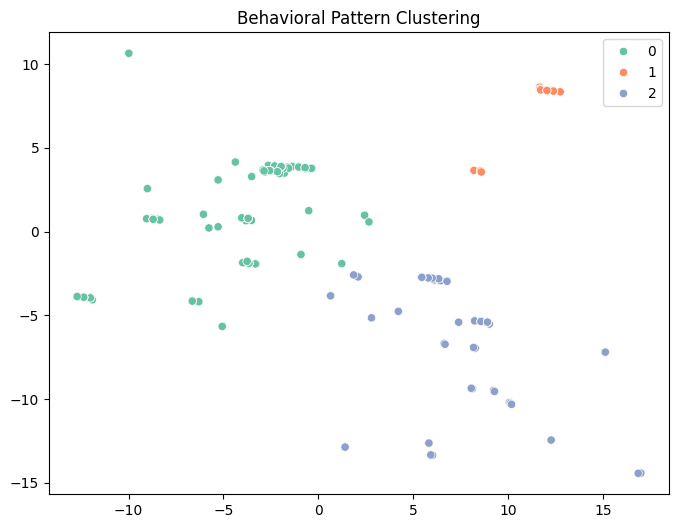

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=kmeans_labels,
    palette='Set2'
)
plt.title("Behavioral Pattern Clustering")
plt.show()
